# Swordfish usage example -- Information Geometry

In [1]:
import swordfish as sf
import numpy as np
import pylab as plt
from numpy.random import multivariate_normal
from tqdm import tqdm
%matplotlib inline
N, M = 25, 50

## Example model definition

### Signal and background fluxes

In [2]:
x = np.linspace(1., 10., 51); dx = x[1]-x[0]

sig_width = 2.
flux_func = lambda sig_norm, sig_pos, bkg_norm: (
    sig_norm/np.sqrt(2*np.pi*sig_width**2)*np.exp(-(x-sig_pos)**2./2./sig_width**2)/sig_pos
    + bkg_norm*np.ones_like(x)
    )*dx

### Background covariance kernel

In [3]:
X,Y = np.meshgrid(x,x)
width = 2.
stddev = 0.01
Sigma = np.exp(-(X-Y)**2/2/width**2)*stddev**2

### Exposure

In [4]:
exposure = np.ones_like(x)*100.

## Calculate expected upper limits with the effective counts method

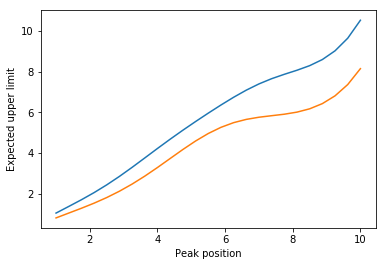

In [5]:
# Instantiate FunkFish object, which builds Swordfish object from function and its variations
FF = sf.Funkfish(flux_func, [0.01, 5., 1.], exposure, Sigma, T = [None, 1e-3, None])
FFN = sf.Funkfish(flux_func, [0.01, 5., 1.], exposure, K = None, T = [None, 1e-3, None])

# Generation of upper limits table
pos_list = np.linspace(1, 10, N)
ul = [FF.EffectiveCounts({1: p}).upperlimit(0, 0.05) for p in pos_list]
ulN = [FFN.EffectiveCounts({1: p}).upperlimit(0, 0.05) for p in pos_list]

# Plot
plt.plot(pos_list, ul)
plt.plot(pos_list, ulN)
plt.xlabel("Peak position")
plt.ylabel("Expected upper limit")

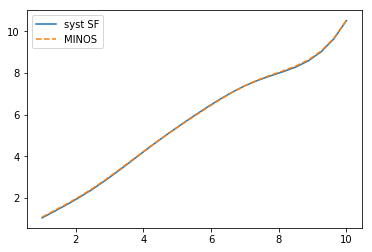

In [6]:
ulM = []
ulMIN = []
for pos in pos_list:
    MI = FF.iminuit({0: 1., 1: pos, 2:1.}, limit_x0 = [0.00001, 10000.])
    MI.print_level = 0
    MI.migrad()
    MI.minos(var = 'x0', sigma = 1.69)
    ulM.append(MI.errors['x0']*1.69)
    ulMIN.append(MI.merrors[('x0',1.0)])
plt.plot(pos_list, ul, label='syst SF')
#plt.plot(pos_list, ulN, label='no syst SF')
plt.plot(pos_list, ulMIN, ls = '--', label='MINOS')
#plt.plot(pos_list, ulM, label='MIGRAD hessian')
plt.legend()

## Reconstruction power

### Map Fisher matrix

In [7]:
norm_list = np.linspace(2, 20, M)
FF = sf.Funkfish(flux_func, [0.00, 2., 1.], exposure, Sigma, T = [None, None, None])
tf = FF.TensorField(1,0, pos_list, norm_list)

### Quiver plot showing major and minor axis of Fisher information metric
Useful for cross-checks. If the figures shows dis-continuities, probably the sample grid needs to be finer.

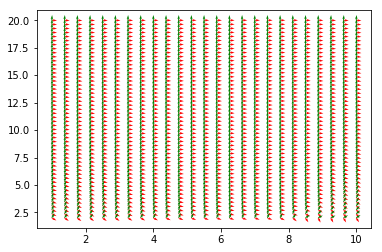

In [8]:
tf.quiver()

### 1, 2, 3-sigma contours from geodesics

In [9]:
def plot_contours(pos, norm):
    for th, ls, pg in zip([1., 2., 3.], ['-', '--', ':'], [False, False, True]):
        tf.contour([pos, norm], th, plot_geodesics = pg, Npoints = 128)

(0, 20)

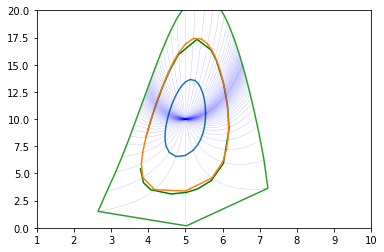

In [10]:
pos = 5.
norm = 10.
FF = sf.Funkfish(flux_func, [norm, pos, 1.], exposure, Sigma, T = [None, None, None])
MI = FF.iminuit()
MI.print_level = 0
MI.migrad()
#c = MI.contour("x1", "x0", subtract_min = True, bound = 3)
#plt.contour(*c, levels = [1., 4., 9.], colors='k')
for sigma in [2,]:
    c = MI.mncontour("x1", "x0", sigma = sigma, numpoints = 20.)
    l = np.array(c[2]).T
    plt.plot(l[0], l[1], c='g')
plot_contours(pos, norm)
plt.xlim([1,10])
plt.ylim([0, 20])

### Visualization of information metric with streamlines

(0, 20)

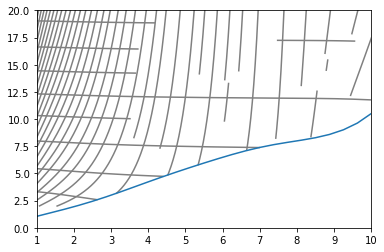

In [11]:
vf1, vf2 = tf.VectorFields()
mask = lambda x, y: (y<20) & (y>np.interp(x, pos_list, ul)) & (x>1) & (x<10)
vf1.streamlines([5,12.], Nmax = 80, Nsteps = 30, mask = mask, color='0.5')
vf2.streamlines([5,12.], Nmax = 80, Nsteps = 30, mask = mask, color='0.5')

plt.plot(pos_list, ul)
plt.xlim([1, 10])
plt.ylim([0, 20])

### Jeffereys prior as estimate for model reconstruction density

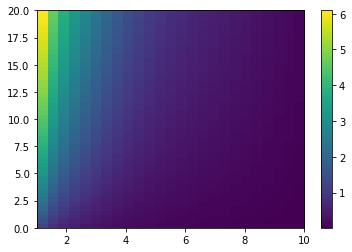

In [12]:
jp = np.array([[np.linalg.det(g)**0.5 for g in row] for row in tf.g])
extent = (1, 10, 0, 20)
plt.imshow(jp[::-1], extent = extent, aspect='auto')
plt.colorbar()